In [1]:
%load_ext autoreload
%autoreload 2

import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams['mathtext.default'] = 'regular'
cmap = mpl.colormaps['plasma']

In [2]:
sheet_names = ['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']
sheet_names_formatted = {
    'V1_Exc_L4': "Layer 4 Exc.",
    'V1_Inh_L4': "Layer 4 Inh.",
    'V1_Exc_L2/3': "Layer 2/3 Exc.",
    'V1_Inh_L2/3': "Layer 2/3 Inh.",
}

In [3]:
class CellRate():

    def __init__(self, prefered_orientation=None):
        self.prefered_orientation = prefered_orientation
        self.gratings_rates = []
        self.gratings_orientations = []
        self.gratings_radius = []
        self.spont_rate = []

    @property
    def grating_orientation_relative(self):
        _rel_orient = []
        for go in self.gratings_orientations:
            _diff = go - self.prefered_orientation
            if _diff < - (numpy.pi / 2):
                _diff += numpy.pi
            if _diff > numpy.pi / 2:
                _diff -= numpy.pi
            _rel_orient.append(_diff)
        return _rel_orient

    def get_mean_rate_for_radius(self, target_radius):
        if not cell.spont_rate:
            return numpy.nan

        _rates = []
        for radius, rate in zip(self.gratings_radius, self.gratings_rates):
            if numpy.isclose(radius, target_radius, atol=0.05):
                _rates.append(rate)# / self.spont_rate)

        return numpy.nanmean(_rates)

# Spontaneous

In [4]:
run_id = "20250116-131433"
for sheet_name in sheet_names:
    datastore_to_pickle(run_id, sheet_name)
data_store = get_data_stores(run_id)[0]

Did not pickle 20250116-131433 because it has already been pickled
Did not pickle 20250116-131433 because it has already been pickled
Did not pickle 20250116-131433 because it has already been pickled
Did not pickle 20250116-131433 because it has already been pickled
Reading folder ./20250116-131433[param.defaults]CombinationParamSearch{25}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:6.31e-05_base_weight:0.000158_base


In [5]:
# Get the spont activity
data_per_sheet = {}
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

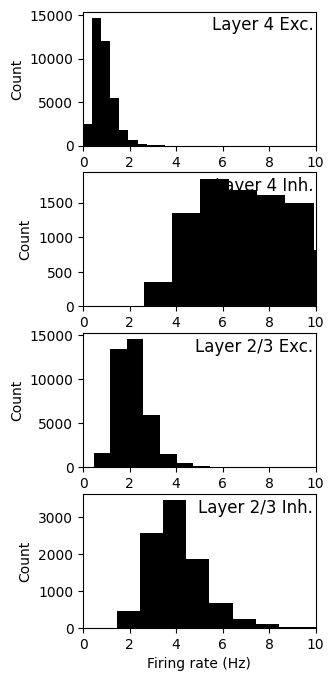

In [6]:
# SANITY TEST:
tolerance = 0.1 # rad
fig, axs = plt.subplots(4, figsize=(3, 8))
for idx_ax, sheet_name in enumerate(sheet_names):
    spont_seg = data_per_sheet[sheet_name]
    axs[idx_ax].hist([1000. * len(st) / spont_seg.duration for st in spont_seg.spiketrains], color="black")
    axs[idx_ax].set_ylabel("Count")
    axs[idx_ax].set_xlim(0, 10)
    axs[idx_ax].set_title(sheet_names_formatted[sheet_name], x=0.99, y=0.80, ha='right') 
axs[-1].set_xlabel("Firing rate (Hz)")
plt.show()

/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


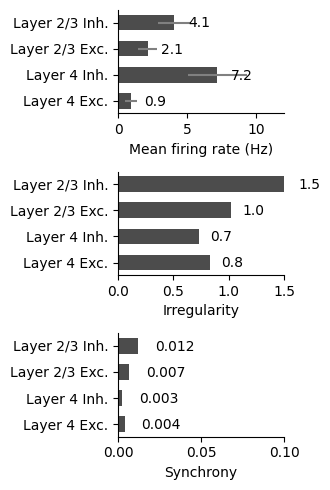

In [7]:
fig, axs = plt.subplots(3, figsize=(3.5, 5))

# Plot the spont activity rate/CC/CV with error bar
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    mean_rate = float(seg.mean_rate)
    std_rate = float(numpy.std([1000. * len(s) / seg.duration for s in seg.spiketrains]))
    axs[0].barh(ypos, mean_rate, height=0.6, color="black", alpha=0.7)
    axs[0].errorbar(mean_rate, ypos, xerr=float(std_rate), color="gray")
    axs[0].text(mean_rate + 1, ypos - 0.19, f"{mean_rate:.1f}")

axs[0].set_xlim(0, 12)
axs[0].set_xlabel("Mean firing rate (Hz)")

# Plot the Irregularity (CV)
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    isis = [numpy.diff(st) for st in seg.spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    cvs = numpy.array([numpy.std(isi) / numpy.mean(isi) for isi in isis])[idxs]
    cv_mean = float(numpy.mean(cvs))
    cv_std = float(numpy.std(cvs))
    axs[1].barh(ypos, cv_mean, height=0.6, color="black", alpha=0.7)
    axs[1].errorbar(mean_rate, ypos, xerr=cv_std, color="gray")
    axs[1].text(cv_mean + 0.1, ypos - 0.19, f"{cv_mean:.1f}")

axs[1].set_xlim(0, 1.5)
axs[1].set_xlabel("Irregularity")

# Plot the Synchrony (CV)
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    spiketrains = seg.spiketrains[:2000]
    isis = [numpy.diff(st) for st in spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    num_bins = int(seg.duration / 10.)
    r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))
    psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]
    corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))
    ccs = corrs[idxs, :][:, idxs][numpy.triu_indices(sum(idxs == True), 1)]
    cc_mean = float(numpy.mean(ccs))
    cc_std = float(numpy.std(ccs))
    axs[2].barh(ypos, cc_mean, height=0.6, color="black", alpha=0.7)
    axs[2].errorbar(mean_rate, ypos, xerr=cc_std, color="gray")
    axs[2].text(cc_mean + 0.01, ypos - 0.19, f"{cc_mean:.3f}")

axs[2].set_xlim(0, 0.1)
axs[2].set_xlabel("Synchrony")

for ax in axs:
    ax.set_yticks(list(range(len(data_per_sheet))))
    ax.set_yticklabels([sheet_names_formatted[n] for n in data_per_sheet.keys()])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Orientation tuning

In [8]:
run_id = "20250116-131433"
for sheet_name in sheet_names:
    datastore_to_pickle(run_id, sheet_name)

Did not pickle 20250116-131433 because it has already been pickled
Did not pickle 20250116-131433 because it has already been pickled
Did not pickle 20250116-131433 because it has already been pickled
Did not pickle 20250116-131433 because it has already been pickled


In [9]:
# Get the OT activity
data_per_sheet = {}
data_spont_per_sheet = {}
data_store = get_data_stores(run_id)[0]
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = [seg for seg in data if 'orientation' in seg.annotation]
    data_spont_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

Reading folder ./20250116-131433[param.defaults]CombinationParamSearch{25}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:6.31e-05_base_weight:0.000158_base


NeuronAnnotationsToPerNeuronValues analysis took: 1.0907866954803467 seconds


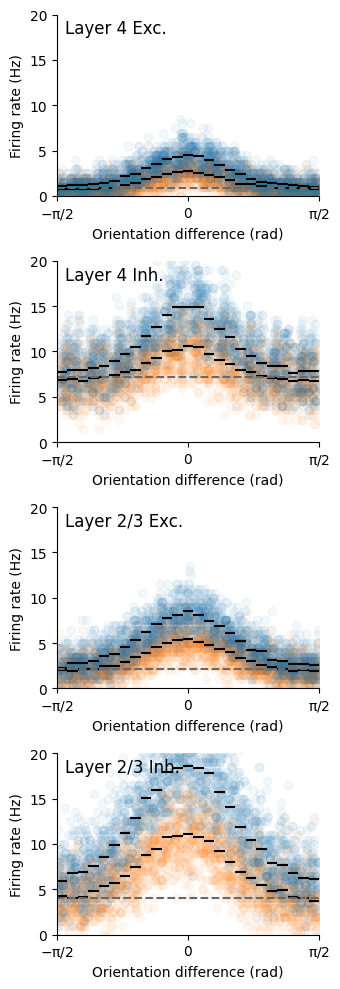

In [10]:
from scipy import stats

fig, axs = plt.subplots(4, figsize=(3.5, 10))

for idx_plot, sheet_name in enumerate(sheet_names):
    for contrast in [10, 100]:

        orientations_cells = get_orientation_preference(data_store, sheet_name).values
        cells = [CellRate(oc) for oc in orientations_cells]

        # Get the gratings fire rate
        for seg in data_per_sheet[sheet_name]:
            if seg.annotation["contrast"] == contrast:
                for idx, st in enumerate(seg.spiketrains):
                    cells[idx].gratings_rates.append(1000. * len(st) / seg.duration)
                    cells[idx].gratings_orientations.append(seg.annotation["orientation"])

        color = "C0" if contrast == 100 else "C1"
        for cell in cells[:100]:
            axs[idx_plot].scatter(cell.grating_orientation_relative, cell.gratings_rates, color=color, alpha=0.05)

        # Binning
        x = []
        y = []
        for cell in cells[:200]:
            x += cell.grating_orientation_relative
            y += cell.gratings_rates
        bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=25, range=(-numpy.pi / 2, numpy.pi / 2))
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        axs[idx_plot].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='black', lw=1.5)
        axs[idx_plot].set_title(sheet_names_formatted[sheet_name], x=0.03, y=0.85, ha='left') 

    # Spontaneous rate
    axs[idx_plot].axhline(data_spont_per_sheet[sheet_name].mean_rate, color='dimgray', lw=1.5, ls='--')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-numpy.pi / 2, numpy.pi / 2)
    ax.set_ylim(0, 20)
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_xlabel("Orientation difference (rad)")
    ax.set_xticks([-numpy.pi / 2, 0, numpy.pi / 2])
    ax.set_xticklabels([r'$-\pi /2$', '0', r'$\pi /2$'])

plt.tight_layout()
plt.show()

# Size tuning

In [11]:
run_id = "20250116-131406"
for sheet_name in ['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']:
    datastore_to_pickle(run_id, sheet_name)

Did not pickle 20250116-131406 because it has already been pickled
Did not pickle 20250116-131406 because it has already been pickled
Did not pickle 20250116-131406 because it has already been pickled
Did not pickle 20250116-131406 because it has already been pickled


In [12]:
# Get the ST activity
data_per_sheet = {}
data_spont_per_sheet = {}
data_store = get_data_stores(run_id)[0]
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = [seg for seg in data if 'orientation' in seg.annotation]
    data_spont_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

Reading folder ./20250116-131406[param.defaults]CombinationParamSearch{25}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:6.31e-05_base_weight:0.000158_base


NeuronAnnotationsToPerNeuronValues analysis took: 1.1709840297698975 seconds


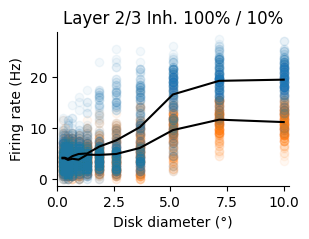

In [13]:
# Population-average size-tuning
tolerance = 0.1 # rad

sheet_name = sheet_names[3]

spont_segment = data_spont_per_sheet[sheet_name]
grating_segments = data_per_sheet[sheet_name]

gratings_orientations = set([seg.annotation['orientation'] for seg in grating_segments if 'orientation' in seg.annotation])
orientations_cells = get_orientation_preference(data_store, sheet_name).values

fig, ax = plt.subplots(1, figsize=(3, 2))

for contrast in [10, 100]:

    cells = [CellRate(oc) for oc in orientations_cells]
    for idx, st in enumerate(spont_segment.spiketrains):
        cells[idx].spont_rate = 1000. * len(st) / spont_segment.duration

    for orientation in gratings_orientations:

        # Get the gratings fire rate
        for seg in grating_segments:
            if 'contrast' in seg.annotation and seg.annotation["contrast"] == contrast:
                for idx, st in enumerate(seg.spiketrains):
                    if numpy.isclose(cells[idx].prefered_orientation, seg.annotation["orientation"], atol=tolerance):
                        cells[idx].gratings_rates.append(1000. * len(st) / seg.duration)
                        cells[idx].gratings_orientations.append(seg.annotation["orientation"])
                        cells[idx].gratings_radius.append(seg.annotation["radius"])

    cells = [c for c in cells if len(c.gratings_rates)]

    color = "C0" if contrast == 100 else "C1"
    for cell in cells[:100]:
        ax.scatter(numpy.array(cell.gratings_radius) * 2, cell.gratings_rates, color=color, alpha=0.05)

    radiuses = sorted(list(set([seg.annotation["radius"] for seg in grating_segments if 'radius' in seg.annotation])))
    mean_rates = []
    for radius in radiuses:
        _means = [c.get_mean_rate_for_radius(radius) for c in cells]      
        mean_rates.append(numpy.nanmean(_means))

    ax.plot(numpy.array(radiuses) * 2, mean_rates, color="black")

ax.set_title(f"{sheet_names_formatted[sheet_name]} 100% / 10%")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, 10.25)
ax.set_ylabel("Firing rate (Hz)")
ax.set_xlabel("Disk diameter (°)")

plt.show()

37500
1325
70 / 1325 (5.283018867924528%)


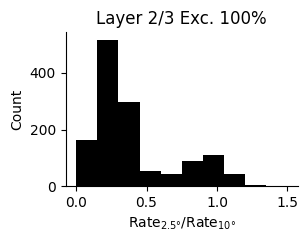

In [14]:
# Cell-specific size tuning
tolerance = 0.1 # rad

sheet_name = sheet_names[2]

spont_segment = data_spont_per_sheet[sheet_name]
grating_segments = data_per_sheet[sheet_name]

gratings_orientations = set([seg.annotation['orientation'] for seg in grating_segments if 'orientation' in seg.annotation])
orientations_cells = get_orientation_preference(data_store, sheet_name).values

contrast = 100

cells = [CellRate(oc) for oc in orientations_cells]
for idx, st in enumerate(spont_segment.spiketrains):
    cells[idx].spont_rate = 1000. * len(st) / spont_segment.duration

for orientation in gratings_orientations:

    # Get the gratings fire rate
    for seg in grating_segments:
        if 'contrast' in seg.annotation and seg.annotation["contrast"] == contrast:
            for idx, st in enumerate(seg.spiketrains):
                if numpy.isclose(cells[idx].prefered_orientation, seg.annotation["orientation"], atol=tolerance):
                    cells[idx].gratings_rates.append(1000. * len(st) / seg.duration)
                    cells[idx].gratings_orientations.append(seg.annotation["orientation"])
                    cells[idx].gratings_radius.append(seg.annotation["radius"])

print(len(cells))
cells = [c for c in cells if len(c.gratings_rates)]
print(len(cells))
radiuses = sorted(list(set([seg.annotation["radius"] for seg in grating_segments if 'radius' in seg.annotation])))

size_tuning = []
for idx_cell, cell in enumerate(cells):

    small_disk_rate = cell.get_mean_rate_for_radius(1.3073)
    full_field_rate = cell.get_mean_rate_for_radius(4.999)
    size_tuning.append(small_disk_rate / full_field_rate)

    if False:
        if size_tuning[-1] > 1.:
            _rates = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
            fig, ax = plt.subplots(1, figsize=(3, 2))
            ax.plot(numpy.array(radiuses) * 2, _rates, color="black")
            ax.scatter(numpy.array(radiuses) * 2, _rates, color="black")
            ax.set_title(f"{sheet_names_formatted[sheet_name]} 100%")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xlim(0, 10.25)
            ax.set_ylabel("Firing rate (Hz)")
            ax.set_xlabel("Disk diameter (°)")
            plt.show()

size_tuning = numpy.array(size_tuning)

print(f"{len(size_tuning[size_tuning > 1])} / {len(size_tuning)} ({100 * len(size_tuning[size_tuning > 1]) / len(size_tuning)}%)")

fig, ax = plt.subplots(1, figsize=(3, 2))
ax.hist(size_tuning, color="black")
ax.set_title(f"{sheet_names_formatted[sheet_name]} 100%")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Count")
ax.set_xlabel(r"$Rate_{2.5°} / Rate_{10°}$")
plt.show()

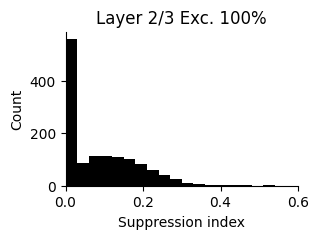

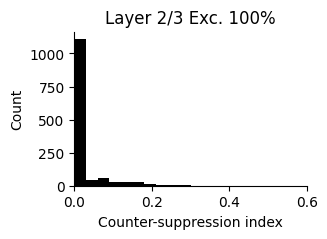

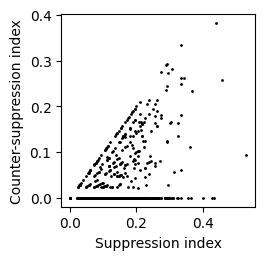

In [15]:
crf_sizes = []
supp_sizes = []
sis = []
max_responses = []
csis = []

for cell in cells:
    
    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = radiuses

    rads, values = zip(*sorted(zip(rads,values)))
                                
    max_response = numpy.max(values)
    crf_index  = numpy.argmax(values)
    crf_size = rads[crf_index]
    
    if crf_index < len(values)-1:
        supp_index = crf_index+numpy.argmin(values[crf_index+1:])+1
    else:
        supp_index = len(values)-1
    supp_size = rads[supp_index]                                
    
    if supp_index < len(values)-1:
        cs_index = supp_index+numpy.argmax(values[supp_index+1:])+1
    else:
        cs_index = len(values)-1

    if values[crf_index] != 0:
        si = (values[crf_index]-values[supp_index])/values[crf_index]
    else:
        si = 0
    
    if values[cs_index] != 0:
        csi = (values[cs_index]-values[supp_index])/values[crf_index]
    else:
        csi = 0
    
    crf_sizes.append(crf_size)
    supp_sizes.append(supp_size)
    sis.append(si)
    max_responses.append(max_response)
    csis.append(csi)

fig, ax = plt.subplots(1, figsize=(3, 2))
ax.hist(sis, color="black", range=(0., 0.6), bins=20)
ax.set_title(f"{sheet_names_formatted[sheet_name]} 100%")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Suppression index")
ax.set_ylabel("Count")
ax.set_xlim(0, 0.6)
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 2))
ax.hist(csis, color="black", range=(0., 0.6), bins=20)
ax.set_title(f"{sheet_names_formatted[sheet_name]} 100%")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Counter-suppression index")
ax.set_ylabel("Count")
ax.set_xlim(0, 0.6)
plt.show()

fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
ax.scatter(sis, csis, color="black", s=1)
ax.set_xlabel("Suppression index")
ax.set_ylabel("Counter-suppression index")
plt.show()

/tmp/ipykernel_722940/3229652211.py:79: RuntimeWarning: divide by zero encountered in divide
  return (p[0] * erf(x / p[1])**2
/tmp/ipykernel_722940/3229652211.py:80: RuntimeWarning: divide by zero encountered in divide
  - p[2] * erf(x / (p[1] + p[3]))**2
/tmp/ipykernel_722940/3229652211.py:11: RuntimeWarning: divide by zero encountered in divide
  return p[0] * erf(x / p[1])**2 - p[2] * erf(x / (p[1] + p[3]))**2 + p[4]


Residual loss evo: 1.6594904613018546
Compute time evo: 0.30s
Residual loss fit: 1.7318570703897476
Compute time fit: 27.26s
[ 8.57767095  0.9295679   8.82350937  2.9784688  15.          3.74739652
  1.4336714 ]
[8.2358261  0.90306333 2.93615986 1.99401542 3.14021375 3.68441205
 1.46100854]


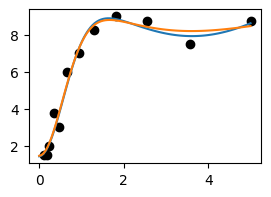


Residual loss evo: 3.366537231884586
Compute time evo: 0.40s
Residual loss fit: 3.378280313634409
Compute time fit: 26.90s
[37.94299029  6.82455786 60.          5.44674997  0.         21.0458251
  1.07395329]
[2.43000881e+01 6.18145762e+00 3.84139969e+01 6.65695515e+00
 2.04216085e+00 8.57037521e-04 1.07864600e+00]


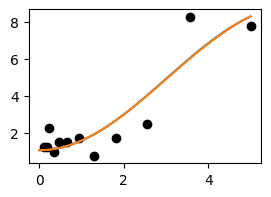


Residual loss evo: 3.391340754510528
Compute time evo: 1.99s
Residual loss fit: 3.4933379560790976
Compute time fit: 26.81s
[37.84035573  4.29240945 60.          3.74523828  0.         25.
  1.35357093]
[17.5873993   3.46169861 46.84600496  9.15514167  0.54009281  0.22523912
  1.35256885]


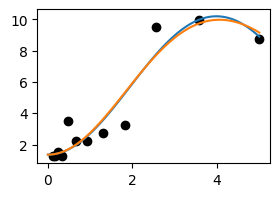


Residual loss evo: 2.319156853716445
Compute time evo: 2.73s
Residual loss fit: 2.3367811832873233
Compute time fit: 26.87s
[54.55981002  3.42438473 59.99980731  0.73327031 15.          4.53917309
  1.42360703]
[19.24372182  3.02223506 20.06087027  2.02022666  3.00893871  2.32824408
  1.42557903]


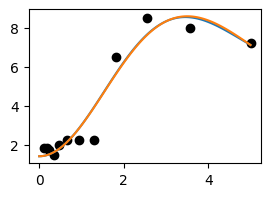


Residual loss evo: 2.5520481302091027
Compute time evo: 1.68s
Residual loss fit: 2.639327698278385
Compute time fit: 26.84s
[37.85467761  4.95624926 59.24021482  3.246767    8.79833913 13.37241128
  0.8329581 ]
[12.37270603  3.67088356 19.23258655  6.13535006  0.          1.32037411
  0.82475738]


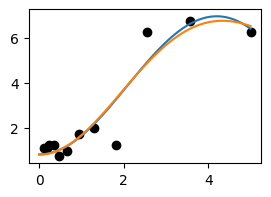


Residual loss evo: 3.5970930907376335
Compute time evo: 1.57s
Residual loss fit: 3.6805199108231053
Compute time fit: 27.05s
[37.01794286  3.90196428 60.          3.53418248  0.          3.106726
  2.31272806]
[18.27811232  3.09843743 40.95513709  6.62370885  1.88125904  0.45341699
  2.24479556]


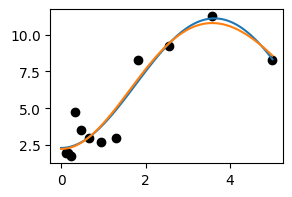


Residual loss evo: 2.835714993520825
Compute time evo: 2.18s
Residual loss fit: 2.8657059714954967
Compute time fit: 27.04s
[58.20584517  3.18336344 59.85385797  0.51716122 15.          4.19505121
  1.5654444 ]
[14.17599529  2.66898752  9.66856201  2.1449129   2.10616169  2.46747355
  1.57293759]


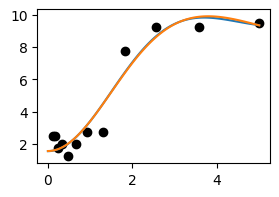


Residual loss evo: 2.6015530338057733
Compute time evo: 2.55s
Residual loss fit: 2.6209816597046127
Compute time fit: 27.04s
[60.          2.19818701 57.20331974  0.28687864 15.         10.71050904
  2.78992256]
[20.03055311  1.95361277 17.63430168  0.96310186  5.5936375   4.17384467
  2.81244623]


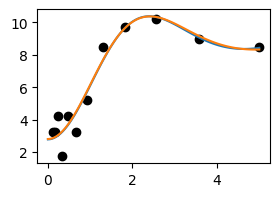


Residual loss evo: 2.452276775943916
Compute time evo: 1.95s
Residual loss fit: 2.5317505978225427
Compute time fit: 26.89s
[37.71273469  4.83129948 60.          4.06315449  0.         14.17948183
  3.63514594]
[17.03189217  3.81859289 26.11539178  5.5619201   5.34706283  1.71971345
  3.58093017]


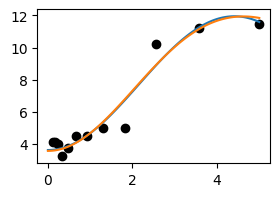


Residual loss evo: 3.15222911256796
Compute time evo: 0.43s


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x74a96c692840> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

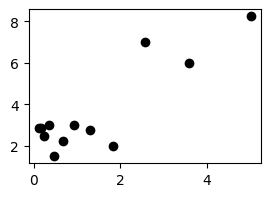

In [100]:
import time
from scipy.optimize import differential_evolution
import functools
import scipy
from scipy.special import erf

def sum_3gaussians(p, x):
    return p[0] * erf(x / p[1])**2 - p[2] * erf(x / (p[1] + p[3]))**2 + p[4] * erf(x / (p[1]+ p[3] + p[5]))**2 + p[6]

def sum_2gaussians(p, x):
    return p[0] * erf(x / p[1])**2 - p[2] * erf(x / (p[1] + p[3]))**2 + p[4]

def error_function3(p, x, y):
    """Computes distance between the function and the target values"""
    return numpy.linalg.norm(sum_3gaussians(p, x) - y)

def error_function2(p, x, y):
    """Computes distance between the function and the target values"""
    return numpy.linalg.norm(sum_2gaussians(p, x) - y)

def fitgaussian(X, Y):

    err = []
    res = []
    initial_guess_fine = [8.0, 0.43, 8.0, 0.18, 3.0, 1.4, numpy.min(Y)] # Initial guess for the parameters
    
    err_st = []
    res_st = []
    initial_guess_coarse = [8.0, 0.43, 8.0, 0.18, numpy.min(Y)] # Initial guess for the parameters
    
    for i in range(2, 30):
        for j in range(5, 22):
          initial_guess_coarse[1] = i/30.0
          initial_guess_coarse[3] = j/20.0
          r = scipy.optimize.fmin_tnc(
              error_function2,
              numpy.array(initial_guess_coarse), 
              args=(numpy.array(X), numpy.array(Y)),
              disp=0,
              bounds=[(0,None), (0,None), (0,None), (0,None), (0,None)],
              approx_grad=True
          )
          res_st.append(r)
          err_st.append(error_function2(r[0], numpy.array(X), numpy.array(Y)))
    
    res_st = res_st[numpy.argmin(err_st)]
    initial_guess_fine[0:4] = res_st[0][0:-1]
    initial_guess_fine[-1] = res_st[0][-1]
    res = []
    for j in range(5, 33):
        for k in range(1, 15):
            initial_guess_fine[3] = j / 30.0
            initial_guess_fine[5] = k / 6.0
            r = scipy.optimize.fmin_tnc(
                error_function3,
                numpy.array(initial_guess_fine),
                args=(numpy.array(X), numpy.array(Y)),
                disp=0, 
                bounds=[(initial_guess_fine[0] * 9 / 10, initial_guess_fine[0]*10/9),
                        (initial_guess_fine[1] * 9 / 10, initial_guess_fine[1]*10/9),
                        (0,None),(0,None),
                        (0,None),(0,None),(0,None)],
                approx_grad=True)
            res.append(r)
            err.append(error_function3(r[0], numpy.array(X), numpy.array(Y)))
    
    x = numpy.linspace(0, X[-1], 100)
    res=res[numpy.argmin(err)]

    if numpy.linalg.norm(Y - numpy.mean(Y), 2) != 0:
        err = numpy.linalg.norm(sum_3gaussians(res[0], X) - Y, 2) / numpy.linalg.norm(Y - numpy.mean(Y), 2)
    else:
        err = 0

    return x, sum_3gaussians(res[0], x), err, res[0]


def sum_3gaussian_evo(p, x):
        return (p[0] * erf(x / p[1])**2
                - p[2] * erf(x / (p[1] + p[3]))**2
                + p[4] * erf(x / (p[1] + p[3] + p[5]))**2
                + p[6])

    
def error_function_evo(p, *args):
    x, y = args
    return np.linalg.norm(sum_3gaussian_evo(p, x) - y)


for cell in cells:

    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = radiuses

    rads, values = zip(*sorted(zip(rads,values)))
    rads = numpy.array(rads)
    values = numpy.array(values)

    fig, ax = plt.subplots(1, figsize=(3, 2))

    ax.scatter(rads, values, color="black")

    print()
    t1 = time.time()
    res = differential_evolution(
        error_function_evo,
        bounds=[(0, 60), (0, 20), (0, 60), (0, 15), (0, 15), (0, 25), (0, 5)],
        args=(rads, values),
        strategy='rand2bin',
        maxiter=10000,
        popsize=30,
        tol=0.1,
        mutation=(0.5, 1.5),
        recombination=0.95,
        workers=1,
    )
    delta_t2 = time.time() - t1
    print(f"Residual loss evo: {error_function_evo(res.x, *(rads, values))}")
    print(f"Compute time evo: {delta_t2:.2f}s")

    t1 = time.time()
    x_fit, values_fit, err, p_fit = fitgaussian(rads, values)
    delta_t = time.time() - t1 
    print(f"Residual loss fit: {error_function3(p_fit, rads, values)}")
    print(f"Compute time fit: {delta_t:.2f}s")

    print(res.x)
    print(p_fit)

    X = numpy.linspace(0, 5, 100)
    ax.plot(X, sum_3gaussian_evo(res.x, X))
    ax.plot(x_fit, values_fit)

    plt.show()

In [113]:
def sum_3gaussian_evo(p, x):
        return (p[0] * erf(x / p[1])**2
                - p[2] * erf(x / (p[1] + p[3]))**2
                + p[4] * erf(x / (p[1] + p[3] + p[5]))**2
                + p[6])

    
def error_function_evo(p, *args):
    x, y = args
    return np.linalg.norm(sum_3gaussian_evo(p, x) - y)


crf_sizes = []
supp_sizes = []
sis = []
max_responses = []
csis = []
errs = []

for idx_cell, cell in enumerate(cells):

    print(idx_cell, len(cells))
    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = radiuses

    rads, values = zip(*sorted(zip(rads,values)))
    rads = numpy.array(rads)
    values = numpy.array(values)

    res = differential_evolution(
        error_function_evo,
        bounds=[(0, 60), (0, 20), (0, 60), (0, 15), (0, 15), (0, 25), (0, 5)],
        args=(rads, values),
        strategy='rand2bin',
        maxiter=10000,
        popsize=30,
        tol=0.1,
        mutation=(0.5, 1.5),
        recombination=0.95,
        workers=1,
    )
    print(f"Residual loss evo: {error_function_evo(res.x, *(rads, values))}")
    errs.append(error_function_evo(res.x, *(rads, values)))

    X_fit = numpy.linspace(0, 5, 100)
    values_fit = sum_3gaussian_evo(res.x, X_fit)

    if False:
        fig, ax = plt.subplots(1, figsize=(3, 2))
        ax.scatter(rads, values, color="black")
        ax.plot(X_fit, values_fit)
        plt.show()

    max_response = numpy.max(values_fit)
    crf_index  = numpy.argmax(values_fit)
    crf_size = X_fit[crf_index]

    if crf_index < len(values_fit)-1:
        supp_index = crf_index+numpy.argmin(values_fit[crf_index+1:])+1
    else:
        supp_index = len(values_fit)-1
    supp_size = X_fit[supp_index]

    if supp_index < len(values_fit)-1:
        cs_index = supp_index+numpy.argmax(values_fit[supp_index+1:])+1
    else:
        cs_index = len(values_fit)-1

    if values_fit[crf_index] != 0:
        si = (values_fit[crf_index]-values_fit[supp_index])/values_fit[crf_index]
    else:
        si = 0

    if values_fit[cs_index] != 0:
        csi = (values_fit[cs_index]-values_fit[supp_index])/values_fit[crf_index]
    else:
        csi = 0

    crf_sizes.append(crf_size)
    supp_sizes.append(supp_size)
    sis.append(si)
    max_responses.append(max_response)
    csis.append(csi)

0 1325


/tmp/ipykernel_722940/4227135460.py:2: RuntimeWarning: divide by zero encountered in divide
  return (p[0] * erf(x / p[1])**2


Residual loss evo: 1.6594905629274632
1 1325
Residual loss evo: 3.3665372318048465
2 1325
Residual loss evo: 3.401577413043055
3 1325
Residual loss evo: 2.3636637782886907
4 1325
Residual loss evo: 2.546727266043252
5 1325
Residual loss evo: 3.597093090778252
6 1325
Residual loss evo: 2.906216681273774
7 1325
Residual loss evo: 2.59101857785968
8 1325
Residual loss evo: 2.4522767765357485
9 1325
Residual loss evo: 3.1504995811481384
10 1325
Residual loss evo: 4.049709916893154
11 1325
Residual loss evo: 2.6811473761001907
12 1325
Residual loss evo: 3.4793210010655677
13 1325
Residual loss evo: 2.417007782686904
14 1325
Residual loss evo: 4.337328314425318
15 1325
Residual loss evo: 4.6237243115806494
16 1325
Residual loss evo: 2.711487545364184
17 1325
Residual loss evo: 2.5176777925781586
18 1325
Residual loss evo: 4.651438653086038
19 1325
Residual loss evo: 3.9487587479023984
20 1325
Residual loss evo: 3.0812818652001943
21 1325


/tmp/ipykernel_722940/4227135460.py:3: RuntimeWarning: divide by zero encountered in divide
  - p[2] * erf(x / (p[1] + p[3]))**2
/tmp/ipykernel_722940/4227135460.py:4: RuntimeWarning: divide by zero encountered in divide
  + p[4] * erf(x / (p[1] + p[3] + p[5]))**2


Residual loss evo: 2.562476903035223
22 1325
Residual loss evo: 2.143865808167491
23 1325
Residual loss evo: 3.223975902500252
24 1325
Residual loss evo: 3.445147215335389
25 1325
Residual loss evo: 2.8228516486636748
26 1325
Residual loss evo: 2.502978784955415
27 1325
Residual loss evo: 2.715066240075424
28 1325
Residual loss evo: 3.080933249053586
29 1325
Residual loss evo: 3.166342975011909
30 1325
Residual loss evo: 1.037330711825053
31 1325
Residual loss evo: 2.771051069559573
32 1325
Residual loss evo: 1.9794467117025663
33 1325
Residual loss evo: 3.345869284919774
34 1325
Residual loss evo: 4.330141946906498
35 1325
Residual loss evo: 1.9768658461982813
36 1325
Residual loss evo: 3.936162622829971
37 1325
Residual loss evo: 3.8300743606172785
38 1325
Residual loss evo: 2.7819018781351037
39 1325
Residual loss evo: 3.508758279800184
40 1325
Residual loss evo: 2.8278729969976393
41 1325
Residual loss evo: 3.21751383375477
42 1325
Residual loss evo: 3.1161989391730844
43 1325
Resi

KeyboardInterrupt: 

In [114]:
# Filter the cell:
sis_filtered = [si for si, er in zip(sis, errs) if er < 3.5]
csis_filtered = [csi for csi, er in zip(csis, errs) if er < 3.5]

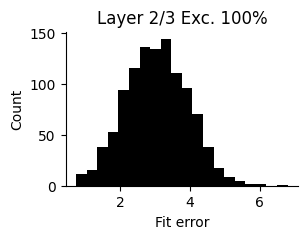

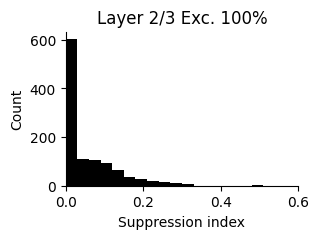

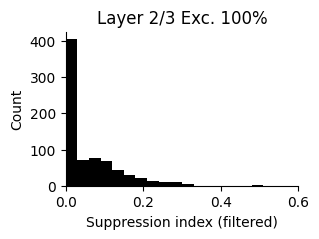

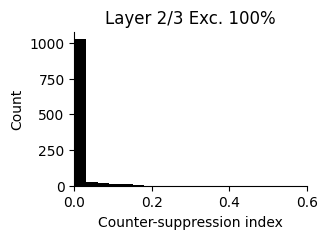

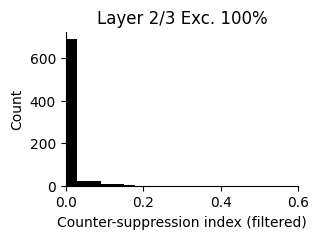

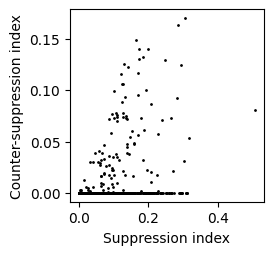

In [115]:
fig, ax = plt.subplots(1, figsize=(3, 2))
ax.hist(errs, color="black", bins=20)
ax.set_title(f"{sheet_names_formatted[sheet_name]} 100%")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Fit error")
ax.set_ylabel("Count")
#ax.set_xlim(0, 0.6)
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 2))
ax.hist(sis, color="black", range=(0., 0.6), bins=20)
ax.set_title(f"{sheet_names_formatted[sheet_name]} 100%")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Suppression index")
ax.set_ylabel("Count")
ax.set_xlim(0, 0.6)
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 2))
ax.hist(sis_filtered, color="black", range=(0., 0.6), bins=20)
ax.set_title(f"{sheet_names_formatted[sheet_name]} 100%")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Suppression index (filtered)")
ax.set_ylabel("Count")
ax.set_xlim(0, 0.6)
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 2))
ax.hist(csis, color="black", range=(0., 0.6), bins=20)
ax.set_title(f"{sheet_names_formatted[sheet_name]} 100%")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Counter-suppression index")
ax.set_ylabel("Count")
ax.set_xlim(0, 0.6)
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 2))
ax.hist(csis_filtered, color="black", range=(0., 0.6), bins=20)
ax.set_title(f"{sheet_names_formatted[sheet_name]} 100%")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Counter-suppression index (filtered)")
ax.set_ylabel("Count")
ax.set_xlim(0, 0.6)
plt.show()

fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
ax.scatter(sis, csis, color="black", s=1)
ax.set_xlabel("Suppression index")
ax.set_ylabel("Counter-suppression index")
plt.show()